In [11]:
import sys
import os
os.chdir("C:\\Users\\Zber\\Documents\\Dev_program\\OpenRadar")
import numpy as np
import mmwave.dsp as dsp
import mmwave.dsp.music as music
import mmwave.clustering as clu
from mmwave.dataloader import DCA1000
from demo.visualizer.visualize import ellipse_visualize
from FER.data_processing.mediapipe_facemesh_one import flm_detector, distance
from scipy import signal

from mmwave.dsp.utils import Window
from mmwave.dsp import utils
import math
from FER.utils import parseConfigFile, arange_tx

from itertools import accumulate
from operator import add
from mmwave.dsp.cfar import ca

from scipy.signal import find_peaks, peak_widths
# import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')

from mpl_toolkits.mplot3d import Axes3D

plt.close('all')

DebugMode = True

if not DebugMode:
    import matplotlib

    matplotlib.use('Agg')

# plotting color
import matplotlib._color_data as mcd

tab_color = [mcd.TABLEAU_COLORS[name] for name in mcd.TABLEAU_COLORS]
extra_color = ['#acc2d9', '#56ae57', '#b2996e', '#a8ff04']
tab_color = tab_color + extra_color

# figpath = "C:/Users/Zber/Desktop/mmWave_figure"
figpath = "C:/Users/Zber/Desktop/SavedFigure"
# configFileName = 'C:/Users/Zber/Desktop/mmWave Configuration/profile_3d_aop_3s.cfg'
configFileName = 'C:/Users/Zber/Desktop/mmWave Configuration/profile_3d_aop_30s_20fps.cfg'

In [12]:

# adc_data_path = "D:/Subjects/S0/joy_1_Raw_0.bin"
# adc_data_path = "D:/Subjects/S1/joy_1_Raw_0.bin"
# adc_data_path = "D:/Subjects/S2/joy_1_Raw_0.bin"
# adc_data_path = "D:/Subjects/S3/joy_1_Raw_0.bin"
# adc_data_path = "D:/Subjects/S4/joy_1_Raw_0.bin"
# adc_data_path = "D:/Subjects/S5/joy_2_Raw_0.bin"
# adc_data_path = "D:/Subjects/S6/joy_1_Raw_0.bin"
# adc_data_path = "D:/Subjects/Distance_150cm/Surprise_1_Raw_0.bin"
# adc_data_path = "D:/Subjects/Distance_300cm/Surprise_1_Raw_0.bin"
adc_data_path = "C:\\Users\\Zber\\Desktop\\Subjects\\Test\\heartbeat_3_Raw_0.bin"


In [13]:
# num Antennas
numTxAntennas = 3
numRxAntennas = 4
# load configure parameters
config = parseConfigFile(configFileName)

# mmWave radar settings
numFrames = config['numFrames']
numADCSamples = config['numAdcSamples']
numLoopsPerFrame = config['numLoops']
numChirpsPerFrame = numTxAntennas * numLoopsPerFrame
numAngleBins = 64

# aoa related
VIRT_ELE_PAIRS = [[8, 2], [9, 3], [10, 4], [11, 5]]
VIRT_AZI_PAIRS = [[i for i in range(0, 8)]]

# azimuth
ANGLE_RES_AZI = 1
ANGLE_RANGE_AZI = 90
ANGLE_BINS_AZI = (ANGLE_RANGE_AZI * 2) // ANGLE_RES_AZI + 1
VIRT_ANT_AZI = 8

# elevation
ANGLE_RES_ELE = 1
ANGLE_RANGE_ELE = 30
ANGLE_BINS_ELE = (ANGLE_RANGE_ELE * 2) // ANGLE_RES_ELE + 1
VIRT_ANT_ELE = 2

BIN_RANG_S = 0
BIN_RANG_E = 256
BINS_PROCESSED = BIN_RANG_E - BIN_RANG_S
VIRT_ANT_AZI_INDEX = [i for i in range(0, 8)]
VIRT_ANT_ELE_INDEX = VIRT_ELE_PAIRS[2]

# data processing parameter
range_resolution, bandwidth = dsp.range_resolution(config['numAdcSamples'],
                                                    dig_out_sample_rate=config['digOutSampleRate'],
                                                    freq_slope_const=config['freqSlopeConst'])

doppler_resolution = dsp.doppler_resolution(bandwidth, start_freq_const=config['startFreq'],
                                            ramp_end_time=config['rampEndTime'],
                                            idle_time_const=config['idleTime'],
                                            num_loops_per_frame=config['numLoops'],
                                            num_tx_antennas=numTxAntennas)

print('Range Resolution: {:.2f}cm, Bandwidth: {:.2f}Ghz, Doppler Resolution: {:.2f}m/s'.format(
    range_resolution * 100, bandwidth / 1000000000, doppler_resolution))


Range Resolution: 4.22cm, Bandwidth: 3.56Ghz, Doppler Resolution: 0.43m/s


In [3]:
range_resolution

0.042158314406249994

In [14]:
# Reading in adc data
adc_data = np.fromfile(adc_data_path, dtype=np.int16)
adc_data = adc_data.reshape(numFrames, -1)
adc_data = np.apply_along_axis(DCA1000.organize_cli, 1, adc_data, num_chirps=numChirpsPerFrame,
                                num_rx=numRxAntennas, num_samples=numADCSamples)
print("Data Loaded!")

# processing range data
# window types : Bartlett, Blackman p, Hanning p and Hamming
# range_data = dsp.range_processing(adc_data)
range_data = dsp.range_processing(adc_data, window_type_1d=Window.HANNING)
range_data = arange_tx(range_data, num_tx=numTxAntennas)

Data Loaded!


(400, 32, 12, 256)


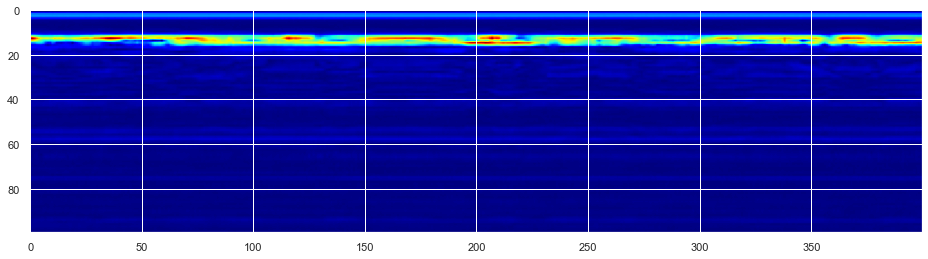

In [15]:
# range profile
print(range_data.shape)
fig5, axes5 = plt.subplots(1, 1, figsize=(16, 9))
range_plot_data = np.mean(range_data[:,15,:,:100],axis=(1))
# range_plot_data = np.mean(range_data,axis=(1,2))
# range_plot_data = range_data[:,15,2,:50]
axes5.imshow(np.abs(range_plot_data.T), cmap=plt.get_cmap('jet'))

In [19]:
# range_plot_data.shape
print(np.argmax(range_plot_data.mean(axis=0)[10:]))

60


# range doppler processing


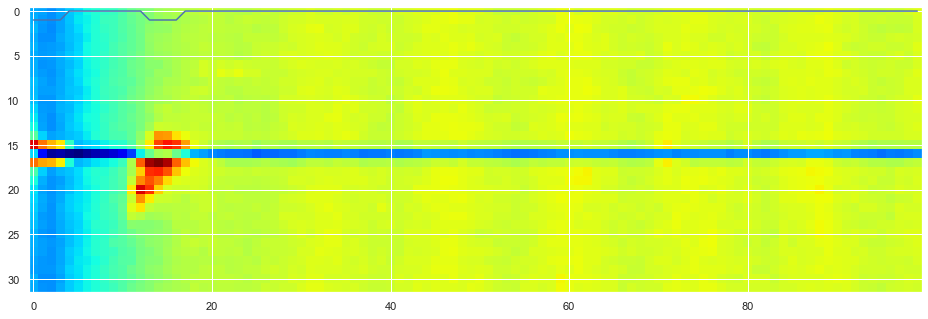

In [13]:
# range_data = range_data - range_data.mean(2, keepdims=True)
# %matplotlib widget
s_bin = 0
e_bin = s_bin + 100
# %matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(16, 9))
det_matrix, aoa_input = dsp.doppler_processing_frame(range_data, num_tx_antennas=numTxAntennas,
                                                    clutter_removal_enabled=True,
                                                    window_type_2d=Window.HAMMING,
                                                    # window_type_2d=None,
                                                    accumulate=True)

# det_matrix, aoa_input = doppler_processing(range_data, num_tx_antennas=numTxAntennas,
#                                                     clutter_removal_enabled=True,
#                                                     window_type_2d=Window.HAMMING,
#                                                     accumulate=True)

det_matrix_vis = np.fft.fftshift(det_matrix, axes=2)
det_matrix_vis_mean = np.mean(det_matrix_vis[:, :, :], axis=0)
# det_matrix_vis_mean = np.mean(det_matrix_vis[50:100, :, :], axis=0)
bin_data = det_matrix_vis_mean[:, 17] + det_matrix_vis_mean[:, 15]

peak_data = ca(bin_data, guard_len=2, noise_len=4, l_bound=8)[s_bin:e_bin]

axes.plot(peak_data)
# axes.axvline(x=20, color='r', linestyle='-')
# axes.axvline(x=24, color='r', linestyle='-')

axes.imshow(np.abs(det_matrix_vis_mean.T[:,s_bin:e_bin]), cmap=plt.get_cmap('jet'))

bin_data


In [14]:
# np.log10(det_matrix_vis_mean)
# np.isnan(det_matrix_vis_mean)

print(det_matrix_vis_mean.sum()==-np.inf)

False


In [15]:
det_matrix_vis.shape
offset = 5
peak_data = peak_data[offset:offset+200]
detect_pos = np.where(peak_data == True)[0]
detect_pos += offset
print(detect_pos)

[13 14 15 16]


In [260]:
# bin_start = detect_pos[0]
# bin_end = detect_pos[-1]

bin_start = 8
bin_end = 12

# bin_start = 27
# bin_end = 30
print("start {}, end {}".format(bin_start, bin_end))
num_vec_azi, steering_vec_azi = dsp.gen_steering_vec(ANGLE_RANGE_AZI, ANGLE_RES_AZI, VIRT_ANT_AZI)
num_vec_ele, steering_vec_ele = dsp.gen_steering_vec(ANGLE_RANGE_ELE, ANGLE_RES_ELE, VIRT_ANT_ELE)

start 8, end 12


In [261]:
print(aoa_input.shape)
aoa_input = np.transpose(aoa_input, (0,3,2,1))
print(aoa_input.shape)

(300, 256, 12, 32)
(300, 32, 12, 256)


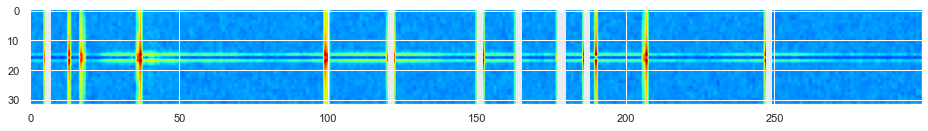

In [262]:
#micro doppler plot
# d_start = 8
# d_end = 11

d_start = bin_start
d_end = bin_end + 1

fig3, axes3 = plt.subplots(1, 1, figsize=(16, 9))
det_matrix_vis_mean = np.mean(det_matrix_vis[:, d_start:d_end, :], axis=1)
axes3.imshow(np.abs(det_matrix_vis_mean.T), cmap=plt.cm.jet)


In [263]:
# capon processing
num_bins = bin_end-bin_start
npy_azi = np.zeros((numFrames, ANGLE_BINS_AZI, num_bins))
npy_ele = np.zeros((numFrames, ANGLE_BINS_ELE, num_bins))
for i in range(0, 300):
    rb = 0
    for r in range(bin_start, bin_end):
        chirp_data_azi= aoa_input[i, :, VIRT_ANT_AZI_INDEX, r]
        # capon beamformer
        capon_angle_azi, beamWeights_azi = dsp.aoa_capon(chirp_data_azi, steering_vec_azi, magnitude=True)
        npy_azi[i, : , rb] = capon_angle_azi

        chirp_data_ele= aoa_input[i, :, VIRT_ANT_ELE_INDEX, r]
        # capon beamformer
        capon_angle_ele, beamWeights_ele = dsp.aoa_capon(chirp_data_ele, steering_vec_ele, magnitude=True)
        npy_ele[i, : , rb] = capon_angle_ele

        rb += 1

In [264]:
# capon processing
ar_sb = 5
ar_eb = 15

# ar_sb = 20
# ar_eb = 30

num_bins = ar_eb - ar_sb
ar_npy_azi = np.zeros((numFrames, ANGLE_BINS_AZI, num_bins))
ar_npy_ele = np.zeros((numFrames, ANGLE_BINS_ELE, num_bins))

range_data = range_data - range_data.mean(2, keepdims=True)

for i in range(0, 300):
    rb = 0
    for r in range(ar_sb, ar_eb):
        chirp_data_azi= range_data[i, :, VIRT_ANT_AZI_INDEX, r]
        # capon beamformer
        capon_angle_azi, beamWeights_azi = dsp.aoa_capon(chirp_data_azi, steering_vec_azi, magnitude=True)
        ar_npy_azi[i, : , rb] = capon_angle_azi

        chirp_data_ele= range_data[i, :, VIRT_ANT_ELE_INDEX, r]
        # capon beamformer
        capon_angle_ele, beamWeights_ele = dsp.aoa_capon(chirp_data_ele, steering_vec_ele, magnitude=True)
        ar_npy_ele[i, : , rb] = capon_angle_ele
        rb += 1

C:\Users\Zber\Documents\Dev_program\OpenRadar\mmwave\dsp\angle_estimation.py:248: RuntimeWarning: invalid value encountered in reciprocal
  den = np.nan_to_num(np.reciprocal(np.einsum('ij,ij->i', steering_vector.conj(), first.T)))


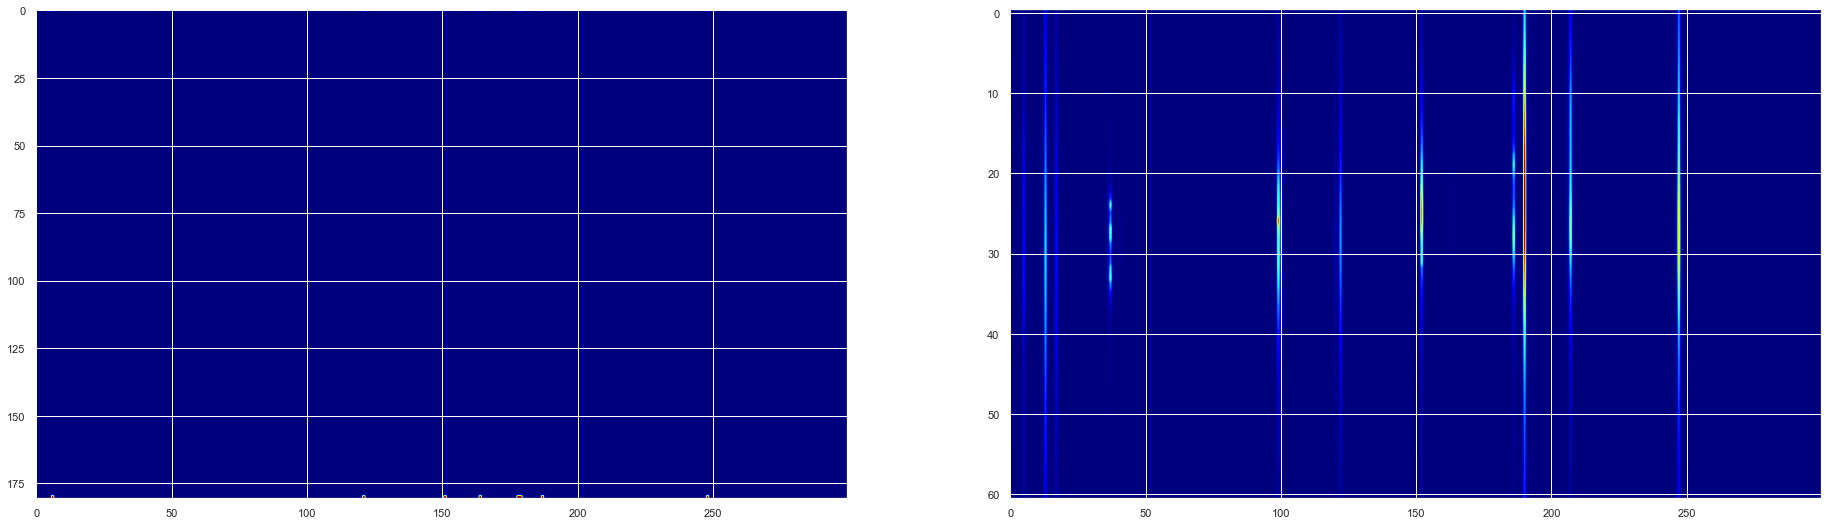

In [265]:
fig1, axes1 = plt.subplots(1, 2, figsize=(32, 9))
axes1[0].imshow(np.mean(npy_azi, 2).T, cmap=plt.cm.jet, aspect='auto')
axes1[1].imshow(np.mean(npy_ele, 2).T, cmap=plt.cm.jet, aspect='auto')

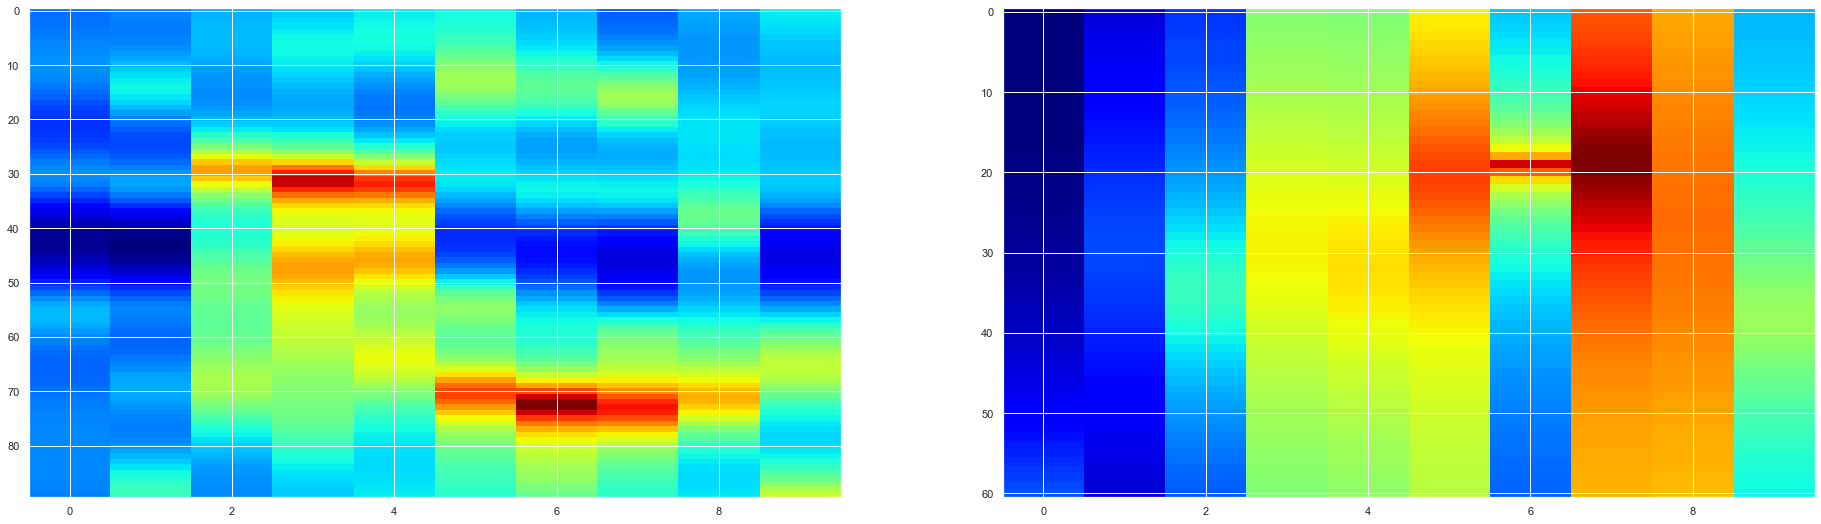

In [159]:
# %matplotlib widget
fig2, axes2 = plt.subplots(1, 2, figsize=(32, 9))
# fig3, axes3 = plt.subplots(1, 1, figsize=(16, 9))
f_num = 50
ar_npy_azi = 20 * np.log10(ar_npy_azi + 1)
ar_npy_ele = 20 * np.log10(ar_npy_ele + 1)
# axes2[0].imshow(ar_npy_azi[f_num], cmap=plt.cm.jet, aspect='auto')
axes2[0].imshow(ar_npy_azi[f_num, 45:135], cmap=plt.cm.jet, aspect='auto')
axes2[1].imshow(ar_npy_ele[f_num], cmap=plt.cm.jet, aspect='auto')
# axes2[1].imshow(np_data[f_num], cmap=plt.cm.jet, aspect='auto')
# axes3.imshow(ar_npy_azi[f_num, 45:135], cmap=plt.cm.jet, aspect='auto')

# axes2[1].imshow(ar_npy_ele[f_num], cmap=plt.cm.jet, aspect='auto')

In [144]:
# bin_path = "C:/Users/Zber/Desktop/Subjects_Heatmap/S4/Joy_1_azi.npy"
bin_path = "C:/Users/Zber/Desktop/Subjects_Heatmap_new/S4/Joy_1_azi.npy"
np_data = np.load(bin_path)
np_data.shape

(300, 181, 10)

In [145]:
ar_npy_azi[5,80]

array([54.54010283, 53.35212393, 75.7959997 , 68.63092226, 64.84058619,
       71.29948253, 66.98076064, 65.5210195 , 59.72605134, 64.48055117])